# Utility functions

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from functools import partial

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.7.0


In [137]:


# convert hex string to unsigned int (es. FF00 -> 65280)
def hex2int_unsigned(hex_val):
    return int(hex_val,16)

# convert hex string to signed int (es. FF00 -> -256)
def hex2int_signed(hexval):
    bits = 16
    val = int(hexval, bits)
    if val & (1 << (bits-1)):
        val -= 1 << bits
    return val


# read text file into pandas DataFrame
def load_trc_file(file_name, skip_rows, n_rows = None):
    data_frame = pd.read_csv(
        file_name,
        delim_whitespace=True, 
        skiprows = skip_rows, 
        header=None, 
        names=["N","O","T","B","I","d","R","L","D0","D1","D2","D3","D4","D5","D6","D7"],
        nrows= n_rows,
        index_col = 'O',
        converters={
            'O': partial(pd.to_datetime,unit='ms',infer_datetime_format=True)
            #    'D0': partial(int, base=16),
        }
        
    )
    return data_frame

# extract posital values
def get_posital_data(data_frame, message_id):
    
    df1 = data_frame[data_frame["I"] == message_id]

    # convert angle from hex bytes to unsigned int
    #df1['P2'] = (df1['D1'] + df1['D0']).apply(hex2int_unsigned)
    df1.loc[:,'P2'] = (df1.loc[:,'D1'] + df1.loc[:,'D0']).apply(hex2int_unsigned)

    # resample at 10 milliseconds
    df1 = df1.resample("10L").ffill()

    return df1


def get_joystick_data(data_frame, message_id):
    # command = df[df["I"] == '02B2']
    df1 = data_frame[data_frame["I"] == message_id]

    # convert set points from hex strings to signed int
    #df1['C2'] = (df1['D1'] + df1['D0']).apply(hex2int_signed)
    #df1['C1'] = (df1['D3'] + df1['D2']).apply(hex2int_signed)
    df1.loc[:,'C2'] = (df1.loc[:,'D1'] + df1.loc[:,'D0']).apply(hex2int_signed)
    df1.loc[:,'C1'] = (df1.loc[:,'D3'] + df1.loc[:,'D2']).apply(hex2int_signed)

    # resample at 10 milliseconds
    df1 = df1.resample("10L").ffill()

    return df1


def merge_columns(cmd, pos, cmd_rolling_length = 1, pos_rolling_length = 1):

    min_rows = min(cmd.shape[0], pos.shape[0])

    #cmd = cmd[['C1','C2']].iloc[0:min_rows].copy()
    cmd = cmd.loc[:,('C1','C2')].iloc[0:min_rows].copy()
    
    cmd = cmd.rolling(cmd_rolling_length).mean()

    #pos = pos[['P2']].iloc[0:min_rows].copy()
    pos = pos.loc[:,'P2'].iloc[0:min_rows].copy()
    
    pos = pos.rolling(pos_rolling_length).mean()

    df1 = pd.merge(cmd, pos, left_index=True, right_index=True)
    df1 = df1.dropna()

    return df1

def plot_joystick_and_position(df1):
    fig, ax = plt.subplots()
    ax2 = ax.twinx()

    df1.plot(y=['P2'], ax=ax)
    df1.plot(y=["C1", "C2"], ax=ax2, ls="--")

    plt.show()


# constants
C1_BASE = 3  # start from columns 3
C1_STEP = 3  # take 3 steps back
C1_SIZE = 33 # was 33 in the ETH model

C2_BASE = C1_BASE+C1_SIZE  # start from columns 3+5
C2_STEP = 3  # take 3 steps back
C2_SIZE = 33 # was 33 in the ETH model


V_BASE = C1_BASE+C1_SIZE+C2_SIZE 
V_STEP = 1 # take 1 step back
V_SIZE = 10 # was 10 in the ETH model

def augment_columns(df3,velocity_filter_length = 1):
    # create columns with past commands
    for i in range(1,C1_SIZE+1):
        df3[C1_BASE+i] = df3['C1'].shift(i*C1_STEP)
        df3.rename(columns={C1_BASE+i:'C1-'+ str(i*C1_STEP)}, inplace=True)

    for i in range(1,C2_SIZE+1):
        df3[C2_BASE+i] = df3['C2'].shift(i*C2_STEP)
        df3.rename(columns={C2_BASE+i:'C2-'+ str(i*C2_STEP)}, inplace=True)

    # create velocities from positions
    df3['V2'] = df3['P2']-df3['P2'].shift(1)

    # filter velocities
    df3['V2'] = df3['V2'].rolling(velocity_filter_length).mean()

    # create delta velocities from velocities
    # df3['DV2'] = df3['V2']-df3['V2'].shift(1)

    # create columns with past velocities
    for i in range(1,V_SIZE+1):
        df3[V_BASE+i] = df3['V2'].shift(i*V_STEP)
        df3.rename(columns={V_BASE+i:'V2-'+ str(i*V_STEP)}, inplace=True) 
    
    df3 = df3.fillna(0)

    return df3


# utility function
def plot_loss(hist, ymax=100):
  plt.plot(hist.history['loss'], label='loss')
  plt.plot(hist.history['val_loss'], label='val_loss')
  plt.ylim([0, ymax])
  plt.xlabel('Epoch')
  plt.ylabel('Error [y]')
  plt.legend()
  plt.grid(True)


def plot_predictions_vs_labels(test_preds, test_lbls, max_value=30):
    a = plt.axes(aspect='equal')
    plt.scatter(test_lbls, test_preds)
    plt.xlabel('True Values [y]')
    plt.ylabel('Predictions [y]')
    lims = [0, max_value]
    plt.xlim(lims)
    plt.ylim(lims)
    _ = plt.plot(lims, lims)


def plot_prediction_error(err):
    plt.hist(err, bins=25)
    plt.xlabel('Prediction Error [y]')
    _ = plt.ylabel('Count')

# Load training File

## Load training file

In [128]:

# adjust training parameters

# data collection
# fname = "../input/posital-2-braccio/Posital 2 braccio.trc"
#fname = "../input/gru-dpx-posital-1-braccio-training/Gru_DPX_Posital_1_braccio_Training.trc"
#train_fname = "/data/workspace_files/Gru_DPX_Posital_1_braccio_Test_Andrea.trc"
train_fname = "/data/workspace_files/Gru_DPX_Posital_1_braccio_Training.trc"

train_skip_rows = 20
train_n_rows = None

posital_message_id='0182'
joystick_message_id='02B1'

# data filter
joystick_rolling_length = 10
position_rolling_length = 10
train_velocity_rolling_length = 1

# keras model
labels_column_names = ['V2']
output_dimension = len(labels_column_names)
model_filename= './model_2'

/opt/python/envs/default/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


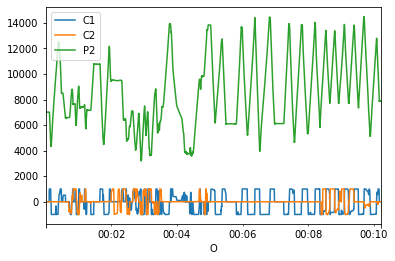

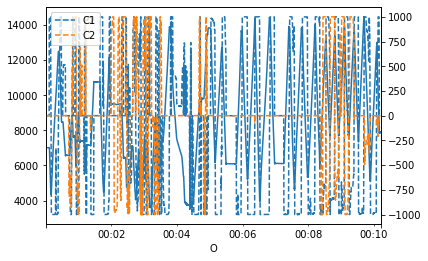

,C1,C2,P2
count,61173.00000,61173.000000,61173.000000
mean,-105.30757,28.767087,8580.938577
std,760.78866,437.561786,2669.349824
min,-1000.00000,-1000.000000,3205.600000
25%,-986.00000,0.000000,6452.200000
50%,0.00000,0.000000,8292.300000
75%,641.60000,0.000000,10624.400000
max,1000.00000,1000.000000,14474.200000


In [121]:
# read text file into pandas DataFrame
df = load_trc_file(file_name=train_fname, skip_rows=train_skip_rows, n_rows=train_n_rows)

# extract posital rows
posital = get_posital_data(df, message_id=posital_message_id)

# extract joystick rows
joystick = get_joystick_data(df, message_id=joystick_message_id)

# merge and plot
train_df2 = merge_columns(joystick, posital, joystick_rolling_length, position_rolling_length)

train_df2.plot()
plot_joystick_and_position(train_df2)
train_df2.describe()

# Train KERAS Model

## Train KERAS Model

In [138]:
# create additional columns
train_df3 = train_df2.copy()
keras_dataset = augment_columns(df3=train_df3, velocity_filter_length=train_velocity_rolling_length)

# split dataset in train and test
train_dataset = keras_dataset.sample(frac=0.8, random_state=0)
test_dataset = keras_dataset.drop(train_dataset.index)

# extract features and labels into separate arrays
train_features = train_dataset.copy()
train_features = train_features.drop(labels_column_names, axis=1)
train_labels = train_dataset.loc[:, labels_column_names]

test_features = test_dataset.copy()
test_features = test_features.drop(labels_column_names, axis=1)
test_labels = test_dataset.loc[:, labels_column_names]

print(f'{test_labels.columns}, {test_features.columns}')

# create a Normalization layer
normalizer = tf.keras.layers.Normalization(axis=-1)  # many variables
# normalizer = tf.keras.layers.Normalization(input_shape=[1,], axis=None) #one variable

# set mean and std for Normalization layer
normalizer.adapt(np.array(train_features))
# print(normalizer.mean.numpy())

Index(['V2'], dtype='object'), Index(['C1', 'C2', 'P2', 'C1-3', 'C1-6', 'C1-9', 'C1-12', 'C1-15', 'C1-18',
       'C1-21', 'C1-24', 'C1-27', 'C1-30', 'C1-33', 'C1-36', 'C1-39', 'C1-42',
       'C1-45', 'C1-48', 'C1-51', 'C1-54', 'C1-57', 'C1-60', 'C1-63', 'C1-66',
       'C1-69', 'C1-72', 'C1-75', 'C1-78', 'C1-81', 'C1-84', 'C1-87', 'C1-90',
       'C1-93', 'C1-96', 'C1-99', 'C2-3', 'C2-6', 'C2-9', 'C2-12', 'C2-15',
       'C2-18', 'C2-21', 'C2-24', 'C2-27', 'C2-30', 'C2-33', 'C2-36', 'C2-39',
       'C2-42', 'C2-45', 'C2-48', 'C2-51', 'C2-54', 'C2-57', 'C2-60', 'C2-63',
       'C2-66', 'C2-69', 'C2-72', 'C2-75', 'C2-78', 'C2-81', 'C2-84', 'C2-87',
       'C2-90', 'C2-93', 'C2-96', 'C2-99', 'V2-1', 'V2-2', 'V2-3', 'V2-4',
       'V2-5', 'V2-6', 'V2-7', 'V2-8', 'V2-9', 'V2-10'],
      dtype='object')


In [139]:
# create keras model

dnn_model = keras.Sequential([
      normalizer,
      layers.Dense(units=128, activation='relu'),
      layers.Dense(units = 128, activation='relu'),
      layers.Dense(units=128, activation='relu'),
      layers.Dense(output_dimension)
  ])

dnn_model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
dnn_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_10 (Normaliza  (None, 79)               159       
 tion)                                                           
                                                                 
 dense_16 (Dense)            (None, 128)               10240     
                                                                 
 dense_17 (Dense)            (None, 128)               16512     
                                                                 
 dense_18 (Dense)            (None, 128)               16512     
                                                                 
 dense_19 (Dense)            (None, 1)                 129       
                                                                 
Total params: 43,552
Trainable params: 43,393
Non-trainable params: 159
________________________________________________

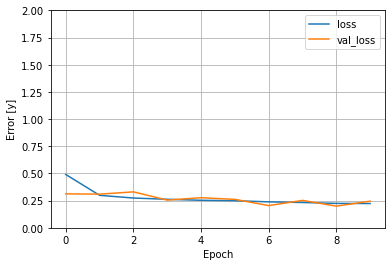

In [140]:
# train keras model

history = dnn_model.fit(
    train_features,
    train_labels,
    validation_split=0.2,
    verbose=0, 
    epochs=10
)

plot_loss(hist= history,ymax=2)

In [141]:
# evaluate model loss with test_data 
test_results = {}
test_results = dnn_model.evaluate(test_features, test_labels, verbose=0)
test_results

0.2417609542608261

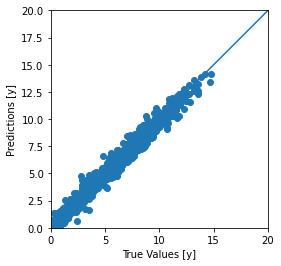

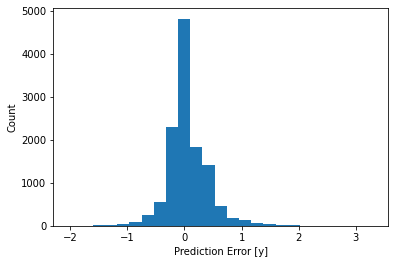

In [142]:
# compare test predictions with test labels
test_predictions = dnn_model.predict(test_features)
plot_predictions_vs_labels(test_predictions, test_labels, max_value=20)
plt.show()

# evaluate predictions error
error = test_predictions - test_labels
plot_prediction_error(error)
plt.show()

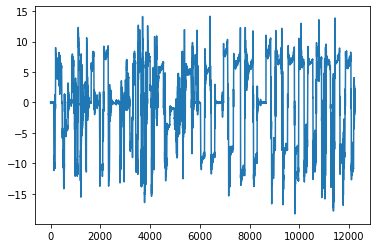

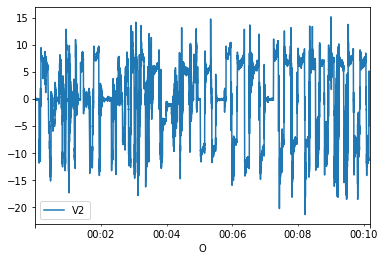

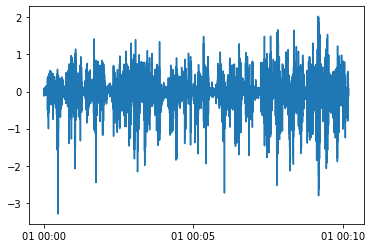

In [143]:
plt.plot(test_predictions), train_df3[labels_column_names].plot()
plt.show()
plt.plot(test_labels - test_predictions)

In [144]:
dnn_model.save(model_filename)
reloaded = tf.keras.models.load_model(model_filename)

INFO:tensorflow:Assets written to: ./model_2/assets


# Load test file

## Load test file

In [145]:
# adjust these parameters

# data collection
test_fname = "/data/workspace_files/Gru_DPX_Posital_1_braccio_Test_Moussa.trc"
test_skip_rows = 20
test_n_rows = None

test_velocity_rolling_length = train_velocity_rolling_length

In [146]:
# read text file into pandas DataFrame
df = load_trc_file(file_name=test_fname, skip_rows=test_skip_rows, n_rows=test_n_rows)
# print(df)

# extract posital rows
test_pos = get_posital_data(df, message_id=posital_message_id)

# extract joystick rows
test_joy = get_joystick_data(df, message_id=joystick_message_id)

/opt/python/envs/default/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


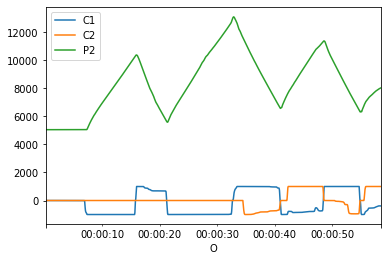

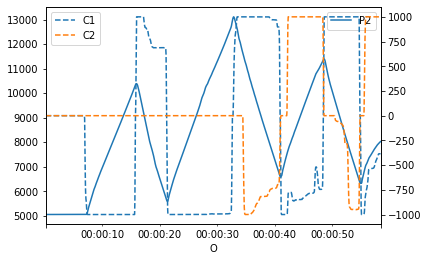

In [147]:
test_df2 = merge_columns(test_joy, test_pos, joystick_rolling_length, position_rolling_length)
test_df2.plot()
plot_joystick_and_position(test_df2)

# Evaluate test file

## Evaluate test file

In [148]:
# create additional columns
test_df3 = test_df2.copy()
keras_dataset = augment_columns(test_df3, velocity_filter_length=test_velocity_rolling_length )
print(keras_dataset)

                            C1      C2      P2   C1-3   C1-6   C1-9  C1-12  \
O                                                                            
1970-01-01 00:00:00.110    0.0     0.0  5055.6    0.0    0.0    0.0    0.0   
1970-01-01 00:00:00.120    0.0     0.0  5055.7    0.0    0.0    0.0    0.0   
1970-01-01 00:00:00.130    0.0     0.0  5055.8    0.0    0.0    0.0    0.0   
1970-01-01 00:00:00.140    0.0     0.0  5055.9    0.0    0.0    0.0    0.0   
1970-01-01 00:00:00.150    0.0     0.0  5056.0    0.0    0.0    0.0    0.0   
...                        ...     ...     ...    ...    ...    ...    ...   
1970-01-01 00:00:58.370 -386.6  1000.0  8016.3 -386.1 -385.5 -384.9 -384.7   
1970-01-01 00:00:58.380 -386.7  1000.0  8018.7 -386.3 -385.7 -385.1 -384.5   
1970-01-01 00:00:58.390 -386.8  1000.0  8021.1 -386.5 -385.9 -385.3 -384.7   
1970-01-01 00:00:58.400 -386.9  1000.0  8023.6 -386.6 -386.1 -385.5 -384.9   
1970-01-01 00:00:58.410 -387.0  1000.0  8026.0 -386.7 -386.3 -38

In [149]:
# use the whole file for testing, there is no training phase

# split dataset in train and test
test_dataset = keras_dataset.copy()

# extract features and labels into separate arrays
test_features = test_dataset.copy()
test_features = test_features.drop(labels_column_names, axis=1)
test_labels = test_dataset.loc[:, labels_column_names]

# evaluate model loss with test_data 
test_results = {}
test_results = dnn_model.evaluate(test_features, test_labels, verbose=0)
test_results

0.2511841058731079

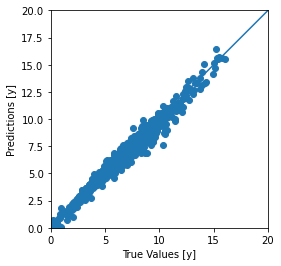

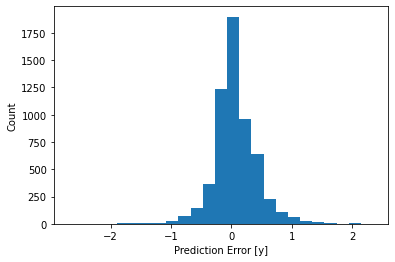

In [150]:
# compare test predictions with test labels
test_predictions = dnn_model.predict(test_features)
plot_predictions_vs_labels(test_predictions, test_labels, max_value=20)
plt.show()

# evaluate predictions error
error = test_predictions - test_labels
plot_prediction_error(error)


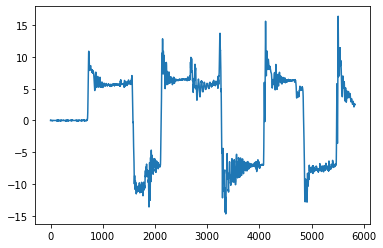

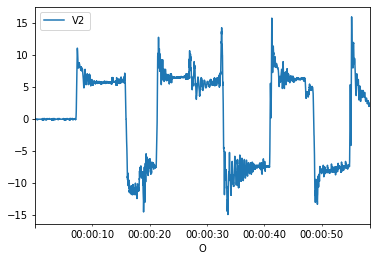

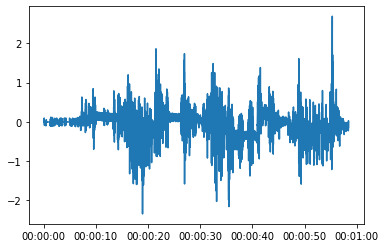

In [151]:
plt.plot(test_predictions),test_df3[labels_column_names].plot()
plt.show()
plt.plot(test_labels - test_predictions)

# Make predictions

## Make predictions

In [152]:

pred_model_filename = 'model_2'
pred_velocity_rolling_length = 1

#cmd_1 = [0, 0, 0, 0, 0, 0, 1000, 1000, 1000, 1000, -1000, -1000, -1000, -1000]
cmd_1 = 1000 * np.ones(1000)
for i in range(0,500): cmd_1[i] = 0
for i in range(600,1000): cmd_1[i] = 0

cmd_2 = np.zeros_like(cmd_1)
pos_2 = np.zeros_like(cmd_1)
  

# Calling DataFrame constructor after zipping both lists, with columns specified
pred_df2 = pd.DataFrame(list(zip(cmd_1, cmd_2, pos_2)),
               columns =['C1', 'C2', 'P2'])
#pred_df2

In [153]:
pred_df3 = pred_df2.copy()
pred_keras_dataset = augment_columns(pred_df3, velocity_filter_length=pred_velocity_rolling_length)
print(pred_keras_dataset)

      C1   C2   P2  C1-3  C1-6  C1-9  C1-12  C1-15  C1-18  C1-21  ...  V2-1  \
0    0.0  0.0  0.0   0.0   0.0   0.0    0.0    0.0    0.0    0.0  ...   0.0   
1    0.0  0.0  0.0   0.0   0.0   0.0    0.0    0.0    0.0    0.0  ...   0.0   
2    0.0  0.0  0.0   0.0   0.0   0.0    0.0    0.0    0.0    0.0  ...   0.0   
3    0.0  0.0  0.0   0.0   0.0   0.0    0.0    0.0    0.0    0.0  ...   0.0   
4    0.0  0.0  0.0   0.0   0.0   0.0    0.0    0.0    0.0    0.0  ...   0.0   
..   ...  ...  ...   ...   ...   ...    ...    ...    ...    ...  ...   ...   
995  0.0  0.0  0.0   0.0   0.0   0.0    0.0    0.0    0.0    0.0  ...   0.0   
996  0.0  0.0  0.0   0.0   0.0   0.0    0.0    0.0    0.0    0.0  ...   0.0   
997  0.0  0.0  0.0   0.0   0.0   0.0    0.0    0.0    0.0    0.0  ...   0.0   
998  0.0  0.0  0.0   0.0   0.0   0.0    0.0    0.0    0.0    0.0  ...   0.0   
999  0.0  0.0  0.0   0.0   0.0   0.0    0.0    0.0    0.0    0.0  ...   0.0   

     V2-2  V2-3  V2-4  V2-5  V2-6  V2-7  V2-8  V2-9

In [154]:
pred_dataset = pred_keras_dataset.copy()

# extract features and labels into separate arrays
pred_features = pred_dataset.copy()
pred_features = pred_features.drop(labels_column_names, axis=1)
pred_labels = pred_dataset.loc[:, labels_column_names]

In [155]:
reloaded_model = tf.keras.models.load_model(pred_model_filename)

In [156]:

rr_base = 400
rr_size = 300
rr = range(rr_base, rr_base + rr_size-1)

pV2 = np.zeros(rr_base + rr_size)


for pred_step in rr:

    # create input dataframe
    pf = pred_features.iloc[range(pred_step,pred_step+1)]
    # print(pf)

    pf = np.zeros_like(pf) 
    pf[0][2] = 10000


    # predict velocity
    # pV2[pred_step] = reloaded_model.predict(pf)
    pV2[pred_step] = dnn_model.predict(pf)


    next_C1 = cmd_1[pred_step + 1]
    next_C2 = cmd_2[pred_step + 1]
    next_P2 = float(pred_features.P2.iloc[pred_step] + pV2[pred_step])

    pred_features['C1'].iloc[pred_step+1] = next_C1
    pred_features['C2'].iloc[pred_step+1] = next_C2
    pred_features['P2'].iloc[pred_step+1] = next_P2

    pred_features['V2-1'].iloc[pred_step+1] = pV2[pred_step]



pred_features.iloc[rr]

#plt.plot(pred_predictions)
 

,C1,C2,P2,C1-3,C1-6,C1-9,C1-12,C1-15,C1-18,C1-21,...,V2-1,V2-2,V2-3,V2-4,V2-5,V2-6,V2-7,V2-8,V2-9,V2-10
400,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
401,0.0,0.0,-0.005042,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.005042,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
402,0.0,0.0,-0.010084,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.005042,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
403,0.0,0.0,-0.015127,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.005042,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
404,0.0,0.0,-0.020169,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.005042,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
694,0.0,0.0,-1.482405,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.005042,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
695,0.0,0.0,-1.487447,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.005042,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
696,0.0,0.0,-1.492489,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.005042,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
697,0.0,0.0,-1.497531,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.005042,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [44]:
pV2

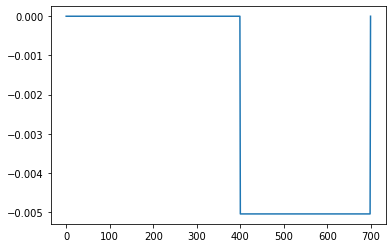

In [157]:
plt.plot(pV2)

<AxesSubplot:>

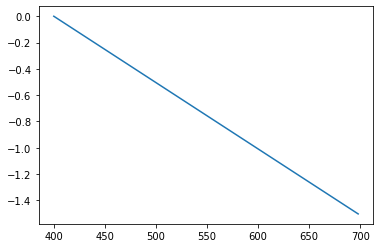

In [159]:
pred_features['P2'].iloc[rr].plot()

# Playground

In [57]:
import numpy as np
import pandas as pd
from collections import deque

def test_queue():

    vel = np.zeros(5)
    cmd = np.zeros(15)

    vel_queue = deque(vel)
    cmd_queue = deque(cmd)
 

    for i in range(1,20):

        vel_queue.appendleft(i)
        vel_queue.pop()

        cmd_queue.appendleft(i)
        cmd_queue.pop()

        print('STEP:', i)
        print('VEL:',vel_queue)
        print('CMD:',cmd_queue)

        vel_list = list(vel_queue)

        cmd_list = []
        for index,value in enumerate(cmd_queue):
            if index in range(0, 15, 3):
                cmd_list.append(value)

    print(cmd_list + vel_list)
    s = list(cmd_queue + vel_queue)
    qdf = pd.DataFrame(s)
    print(qdf.transpose())

test_queue()

STEP: 1
VEL: deque([1, 0.0, 0.0, 0.0, 0.0])
CMD: deque([1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
STEP: 2
VEL: deque([2, 1, 0.0, 0.0, 0.0])
CMD: deque([2, 1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
STEP: 3
VEL: deque([3, 2, 1, 0.0, 0.0])
CMD: deque([3, 2, 1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
STEP: 4
VEL: deque([4, 3, 2, 1, 0.0])
CMD: deque([4, 3, 2, 1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
STEP: 5
VEL: deque([5, 4, 3, 2, 1])
CMD: deque([5, 4, 3, 2, 1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
STEP: 6
VEL: deque([6, 5, 4, 3, 2])
CMD: deque([6, 5, 4, 3, 2, 1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
STEP: 7
VEL: deque([7, 6, 5, 4, 3])
CMD: deque([7, 6, 5, 4, 3, 2, 1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
STEP: 8
VEL: deque([8, 7, 6, 5, 4])
CMD: deque([8, 7, 6, 5, 4, 3, 2, 1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
STEP: 9
VEL: deque([9, 8, 7, 6, 5])
CMD: deque([9, 8, 7, 6, 

In [45]:
num = []
cmd = np.zeros(15)
cmd_queue = deque(cmd)
a = list(cmd_queue)

b = []
for index,value in enumerate(a):
    if index in range(0, 15, 3):
        b.append(value)
a+b

df = pd.DataFrame(a)
df.transpose()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
